In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm

import pickle

from joblib import Parallel, delayed

/mnt/c/Users/hhelm/virtualenvs/hh/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Should use this class to generate CIFAR fig..
class LifelongForest:
    """
    Lifelong Forest class.
    """
    def __init__(self, acorn=None):
        """
        Two major things the Forest Class needs access to:
            1) the realized random forest model (self.models_ is a list of forests, 1 for each task)
            2) old data (to update posteriors when a new task is introduced)
        """
        self.models_ = []
        self.X_ = []
        self.y_ = []
        self.n_tasks = 0
        self.n_classes = None
        
        if acorn is not None:
            np.random.seed(acorn)
    
    def new_forest(self, X, y, n_estimators=200, max_samples=0.32,
                        bootstrap=True, max_depth=30, min_samples_leaf=1,
                        acorn=None):
        """
        Input
        X: an array-like object of features; X.shape == (n_samples, n_features)
        y: an array-like object of class labels; len(y) == n_samples
        n_estimators: int; number of trees to construct (default = 200)
        max_samples: float in (0, 1]: number of samples to consider when 
            constructing a new tree (default = 0.32)
        bootstrap: bool; If True then the samples are sampled with replacement
        max_depth: int; maximum depth of a tree
        min_samples_leaf: int; minimum number of samples in a leaf node
        
        Return
        model: a BaggingClassifier fit to X, y
        """
        
        if X.ndim == 1:
            raise ValueError('1d data will cause headaches down the road')
            
        if acorn is not None:
            np.random.seed(acorn)
            
        self.X_.append(X)
        self.y_.append(y)
            
        n = X.shape[0]
        K = len(np.unique(y))
        
        if self.n_classes is None:
            self.n_classes = K
        
        max_features = int(np.ceil(np.sqrt(X.shape[1])))

        model=BaggingClassifier(DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                                                         max_features = max_features),
                                  n_estimators=n_estimators,
                                  max_samples=max_samples,
                                  bootstrap=bootstrap)

        model.fit(X, y)
        self.models_.append(model)
        self.n_tasks += 1
        self.n_classes = len(np.unique(y))
        
        return model
    
    
    def _get_leaves(self, estimator):
        """
        Internal function to get leaf node ids of estimator.
        
        Input
        estimator: a fit DecisionTreeClassifier
        
        Return
        leaf_ids: numpy array; an array of leaf node ids
        
        Usage
        _estimate_posteriors(..)
        """
        
        # adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
        n_nodes = estimator.tree_.node_count
        children_left = estimator.tree_.children_left
        children_right = estimator.tree_.children_right
        feature = estimator.tree_.feature
        threshold = estimator.tree_.threshold

        leaf_ids = []
        stack = [(0, -1)] 
        while len(stack) > 0:
            node_id, parent_depth = stack.pop()

            # If we have a test node
            if (children_left[node_id] != children_right[node_id]):
                stack.append((children_left[node_id], parent_depth + 1))
                stack.append((children_right[node_id], parent_depth + 1))
            else:
                leaf_ids.append(node_id)

        return np.array(leaf_ids)
    
    
    def _finite_sample_correction(self, class_probs, row_sums):
        """
        An internal function for finite sample correction of posterior estimation.
        
        Input
        class_probs: numpy array; array of posteriors to correct
        row_sums: numpy array; array of partition counts
        
        Output
        class_probs: numpy array; finite sample corrected posteriors
        
        Usage
        _estimate_posteriors(..)
        
        """
    
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (2 * row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1 / (2 * row_sums[elem[0], None])
    
        return class_probs
    
    
    def _estimate_posteriors(self, test, representation=0, decider=0, subsample=1, acorn=None):
        """
        An internal function to estimate the posteriors.
        
        Input
        task_number: int; indicates which model in self.model_ to use
        test: array-like; test observation
        in_task: bool; True if test is an in-task observation(s)
        subsample: float in (0, 1]; proportion of out-of-task samples to use to
            estimate posteriors
            
        Return
        probs: numpy array; probs[i, k] is the probability of observation i
            being class k
            
        Usage
        predict(..)
        """
        
        if acorn is not None:
            acorn = np.random.seed(acorn)
            
        if representation==decider:
            in_task=True
        else:
            in_task=False
            
        train = self.X_[decider]
        y = self.y_[decider]
            
        model = self.models_[representation]

        n, d = train.shape
        
        if test.ndim > 1:
            m, d_ = test.shape
        else:
            m = len(test)
            d_ = 1
        
        size = len(np.unique(y))
        class_counts = np.zeros((m, size))
        for tree in model:
            # get out of bag indicies
            if in_task:
                prob_indices = _generate_unsampled_indices(tree.random_state, n)
                # in_bag_idx = _generate_sample_indices(tree.random_state, n) # this is not behaving as i expected
            else:
                prob_indices = np.random.choice(range(n), size=int(subsample*n), replace=False)

            leaf_nodes = self._get_leaves(tree)
            unique_leaf_nodes = np.unique(leaf_nodes)

            # get all node counts
            node_counts = tree.tree_.n_node_samples
            # get probs for eval samples
            posterior_class_counts = np.zeros((len(unique_leaf_nodes), size))

            for prob_index in prob_indices:
                temp_node = tree.apply(train[prob_index].reshape(1, -1)).item()
                posterior_class_counts[np.where(unique_leaf_nodes == temp_node)[0][0], y[prob_index]] += 1

            # total number of points in a node
            row_sums = posterior_class_counts.sum(axis=1)

            # no divide by zero
            row_sums[row_sums == 0] = 1

            # posteriors
            class_probs = (posterior_class_counts / row_sums[:, None])
            # posteriors with finite sampling correction

            class_probs = self._finite_sample_correction(class_probs, row_sums)

            # posteriors as a list
            class_probs.tolist()

            partition_counts = np.asarray([node_counts[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)])
            # get probability for out of bag samples
            eval_class_probs = [class_probs[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)]
            eval_class_probs = np.array(eval_class_probs)
            # find total elements for out of bag samples
            elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
            # store counts for each x (repeat fhis for each tree)
            class_counts += elems
        # calculate p(y|X = x) for all x's
        probs = class_counts / class_counts.sum(axis=1, keepdims=True)

        return probs


    def predict(self, test, representation=0, decider='all', subsample=1, acorn=None):
        """
        Predicts the class labels for each sample in test.
        
        Input
        test: array-like; either a 1d array of length n_features
            or a 2d array of shape (m, n_features) 
        task_number: int; task number 
        """
        
        size=len(np.unique(self.y_[decider]))
        sum_posteriors = np.zeros((test.shape[0], size))
        
        if representation is 'all':
            for i in range(self.n_tasks):
                sum_posteriors += self._estimate_posteriors(test,
                                                            i,
                                                            decider,
                                                            subsample,
                                                            acorn)
            
        else:
            sum_posteriors += self._estimate_posteriors(test,
                                                        representation,
                                                        decider,
                                                        subsample,
                                                        acorn)
                
        return np.argmax(sum_posteriors, axis=1)

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def homogenize_labels(a):
    u = np.unique(a)
    return np.array([np.where(u == i)[0][0] for i in a])

In [5]:
n_tasks=10
train_file = 'cifar-100-python/train'
unpickled_train = unpickle(train_file)
train_keys = list(unpickled_train.keys())
fine_labels = np.array(unpickled_train[train_keys[2]])

train_data = unpickled_train[list(train_keys)[-1]]
class_idx = [np.where(fine_labels == u)[0] for u in np.unique(fine_labels)]

train_labels = -1*np.ones(train_data.shape[0])
for i, class_ in enumerate(class_idx):
    train_labels[class_] = i
    
train_by_task = [np.concatenate(class_idx[i*n_tasks: (i+1)*n_tasks]) for i in range(n_tasks)]

K = int(len(class_idx)/n_tasks)

test_file = 'cifar-100-python/test'
unpickled_test = unpickle(test_file)
test_keys = list(unpickled_test.keys())
test_labels = np.array(unpickled_test[test_keys[2]])

test_data = unpickled_test[test_keys[-1]]
test_class_idx = [np.where(test_labels == u)[0] for u in np.unique(test_labels)]
test_by_task = [np.concatenate(test_class_idx[i*n_tasks: (i+1)*n_tasks]) for i in range(n_tasks)]

In [18]:
n_trees = 41
X = train_data[train_by_task[0]]
y = homogenize_labels(train_labels[train_by_task[0]])

X_test = test_data[test_by_task[0]]
y_test = homogenize_labels(test_labels[test_by_task[0]])

errors = np.zeros(n_tasks)
base_error = 0

for i in tqdm(range(n_tasks)):
    lf = LifelongForest()
    lf.new_forest(X, y, n_estimators=n_trees*(i+1))
    
    temp_pred = lf.predict(X_test, representation=0, decider=0)
    
    
    errors[i] = np.mean(temp_pred == y_test)

100%|██████████| 10/10 [20:10<00:00, 172.01s/it]


In [24]:
more_errors = np.zeros(n_tasks)

for i, ii in enumerate(tqdm(range(n_tasks, 2*n_tasks))):
    lf = LifelongForest()
    lf.new_forest(X, y, n_estimators=n_trees*(ii+1))
    
    temp_pred = lf.predict(X_test, representation=0, decider=0)
    
    
    more_errors[i] = np.mean(temp_pred == y_test)

100%|██████████| 10/10 [46:47<00:00, 317.81s/it]


In [26]:
errors = np.concatenate((errors, more_errors))

Text(0, 0.5, '"BTE"')

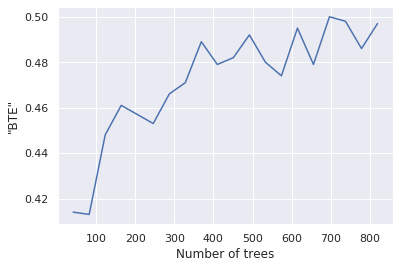

In [29]:
fig, ax = plt.subplots(1,1)

ax.plot(n_trees * np.arange(1, 2*n_tasks+1), errors)
ax.set_xlabel('Number of trees')
ax.set_ylabel('"BTE"')



# plt.savefig('pure_resource_building_task1.pdf')